# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Initial Data Cleaning
- Step 1: due to the large volume of original data, load the first 100000 observations of the population data before building an ETL function that cleans the real data.

In [2]:
# load in the first 100K observations of the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows= 100000)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Part 1: Data Mining
- Develop a data cleaning pipeline using the azdias data

First, load the dataset of attribute info

In [4]:
## the attributes data
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
attributes.fillna(method = 'ffill', inplace = True)
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


#### Missing Values
According to the attribute values table, some missing values are not encoded as NA. They have other values like -1.

In [5]:
## to take care of missing values - the word 'unknown'
attr_missing = attributes[attributes['Meaning'] == 'unknown']
attr_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [6]:
unknown_values = []
for val in attr_missing.Value:
    ## evaluate whether missing 'value' is an integer (one digit)
    if isinstance(val, int):
        unknown_values.append([val])
    ## evaluate whether attribute has more than one value (a string object in the dataframe)
    elif isinstance(val, str):
        split_list = val.split(',')
        int_list = [int(x) for x in split_list]
        unknown_values.append(int_list)

unknown_dict = {}
for attr, value_list in zip(attr_missing.Attribute, unknown_values):
    unknown_dict[attr] = value_list
    
unknown_dict['GEBURTSJAHR'] = [0]

In [7]:
unknown_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

In [8]:
azdias_clean = azdias.copy()
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
## use dictionary to replace missing values with NaN
for key in unknown_dict:
    for x in unknown_dict[key]:
        try:
            azdias_clean[key] = azdias_clean[key].replace(x, np.nan)
            
        except:
            ## print columns that are in the attribute list but not on the data
            print(key)
            continue

BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB
WACHSTUMSGEBIET_NB


In [10]:
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
## how many missing values are there?

attr_miss = pd.DataFrame(azdias_clean.isnull().mean() * 100, columns = ['pct_miss'])
attr_miss.head()

,pct_miss
LNR,0.000
AGER_TYP,76.222
AKT_DAT_KL,8.385
ALTER_HH,8.385
ALTER_KIND1,90.908


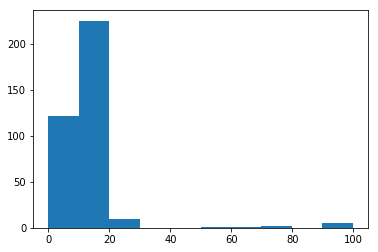

In [12]:
plt.hist(attr_miss['pct_miss']);

- Drop all columns with over 40% of data missing

In [13]:
miss_cols = attr_miss[attr_miss['pct_miss'] > 40]
drop_cols = miss_cols.index
drop_cols

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [14]:
azdias_clean.drop(columns = list(drop_cols), inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [15]:
obs_miss = pd.DataFrame(azdias_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])
obs_miss.head()


,pct_miss
0,69.747899
1,2.521008
2,0.000000
3,1.120448
4,0.000000


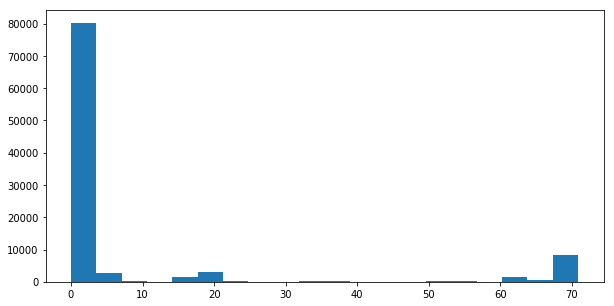

In [16]:
plt.figure(figsize = (10, 5))
plt.hist(obs_miss['pct_miss'], bins = 20);

In [17]:
obs_miss.shape

(100000, 1)

In [18]:
(obs_miss['pct_miss'] > 25).sum()

11881

In [19]:
## how many observations contain more than half missing data?
(obs_miss['pct_miss'] > 50).sum() / azdias_clean.shape[0]

0.11246

In [20]:
miss_50 = obs_miss[obs_miss['pct_miss'] > 50]
miss_50_idxs = list(miss_50.index)

In [21]:
len(miss_50_idxs)

11246

In [22]:
azdias_clean.drop(index= miss_50_idxs, inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


#### Categorical Variables

In [23]:
## investigate the datatypes
azdias_types = pd.DataFrame(azdias_clean.dtypes, columns = ['dtype'])

## get categorical variables
azdias_objects = azdias_types[azdias_types['dtype'] == 'object']
cat_variables = azdias_objects.index.tolist()

In [24]:
azdias_cat = azdias_clean[cat_variables]
azdias_cat.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


In [25]:
azdias_cat.nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               2467
OST_WEST_KZ                    2
dtype: int64

- `CAMEO_DEU_2015` and `CAMEO_INTL_2015` could be split in two and dummied - consult my previous project or feature information
- `CAMEO_DEUG_2015` could be converted into integers
- `EINGEFUEGT_AM` should be dropped as it contains dates and does not seem important
- `D19_LETZTER_KAUF_BRANCHE` should be dropped since there is information about D19 features and this one is not in the feature dictionary and it does not contain entries similar to any of the D19 features.
- `OST_WEST_KZ` should be dummied (W = 1, O = 0)

In [26]:
## split into wealth and life stage
azdias_clean['CAMEO_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[0]
azdias_clean['LIFE_STAGE_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[1]

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,8,A
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,4,C
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,2,A
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,6,B
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4.0,6.0,9.0,7.0,4,2,1,8,C


In [27]:
## replace 'X' with NaN
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[0]
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['WEALTH_INTL_2015'].replace('n', np.nan)

azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[1]
azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


In [28]:

## replace value X for NaN and covert to float
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].astype(float)

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


- Modify the `PRAEGENDE_JUGENDJAHRE` feature such that it contains a person's decade, 'avantgarde' and 'mainstream'

In [29]:
# temporally change nan values to 0 so that a for loop changes it back
azdias_clean['PRAEGENDE_JUGENDJAHRE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
               7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

## create decade (interval), movement (binary)
decade = []
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    decade.append(decades_p_j[x])

## add decade variable to dataframe
azdias_clean['DECADE'] = decade

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,9.0,4.0,5,2,1,8,A,5,1,90.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,2.0,5,2,3,4,C,2,4,90.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3,2,4,2,A,1,2,70.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,9.0,3.0,4,1,3,6,B,4,3,70.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,9.0,7.0,4,2,1,8,C,5,4,50.0


In [30]:
# variable: dimension - list of values
## Movement - Mainstream: [1, 3, 5, 8, 10, 12, 14]
## Movement - Avantgarde: [2, 4, 6, 7, 9, 11, 13, 15]

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

movement = [] ## movement -> 1: mainstream, 0: avantgarde
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    if x in mainstream:
        movement.append(1)
    elif x in avantgarde:
        movement.append(0)
    else:
        movement.append(np.nan)
        
azdias_clean['MOVEMENT_MAINSTREAM'] = movement
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [31]:
## drop the variable
azdias_clean.drop(columns = ['PRAEGENDE_JUGENDJAHRE', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], inplace = True)
azdias_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


#### Additional Variables
- Investigate `MIN_GEBAEUDEJAHR`, `KBA13_ANZAHL_PKW`, and `GEBURTSJAHR`
    - Drop `MIN_GEBAEUDEJAHR`
    - Keep `KBA13_ANZAHL_PKW`
    - Modify `GEBURTSJAHR` to `AGE`(as of 2020) as a proper numeric variable after filling missing values

In [ ]:
azdias_clean.drop(columns = ['MIN_GEBAEUDEJAHR'], inplace = True)

In [ ]:
mean_PKW = round(azdias_clean['KBA13_ANZAHL_PKW'].mean())
azdias_clean['KBA13_ANZAHL_PKW'] = azdias_clean['KBA13_ANZAHL_PKW'].replace(np.nan, mean_PKW)
azdias_clean.head()

#### Fill in Missing Values
- For this analysis, fill in missing values userg forward and backward fill

In [32]:
df_clean_fill = azdias_clean.ffill(axis = 'rows')
df_clean_fill.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [33]:
df_clean_fill = df_clean_fill.bfill(axis = 'rows')
df_clean_fill.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [34]:
df_clean_fill.isnull().sum().sum()

0

### Make Dummy Variables

In [35]:
## make dummy variables
dum_features = ['WEALTH_DEU_2015', 'LIFE_STAGE_DEU_2015', 'WEALTH_INTL_2015', 'LIFE_STAGE_INTL_2015', 'OST_WEST_KZ', 'DECADE']

azdias_clean_dum = pd.get_dummies(df_clean_fill, columns = dum_features, drop_first= True)

azdias_clean_dum.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [36]:
azdias_clean_dum.shape

(88754, 378)

### 2. Cleaning Pipeline

In [37]:
def clean_data(df):
    
    ## 1 - load the attributes data
    print('Step 1 of 7')
    attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
    ## fill in missing values
    attributes.fillna(method = 'ffill', inplace = True)
    
    ## get unknown values from the attributes table
    attr_missing = attributes[attributes['Meaning'] == 'unknown']
    
    
    ## 2 - Modify missing values
    print('Step 2 of 7')
    unknown_values = []
    for val in attr_missing.Value:
        ## evaluate whether missing 'value' is an integer (one digit)
        if isinstance(val, int):
            unknown_values.append([val])
        ## evaluate whether attribute has more than one value (a string object in the dataframe)
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)
            
    ## create dictionary of missing values
    unknown_dict = {}
    for attr, value_list in zip(attr_missing.Attribute, unknown_values):
        unknown_dict[attr] = value_list
        
    ## additional variable for NaN value
    unknown_dict['GEBURTSJAHR'] = [0]
        
    ## use dictionary to replace missing values with NaN
    df_clean = df.copy()
    
    for key in unknown_dict:
        for x in unknown_dict[key]:
            try:
                df_clean[key] = df_clean[key].replace(x, np.nan)

            except:
                ## move on for columns that are in the attribute list but not on the data
                continue
    
    ## 3 - Handle missing values
    print('Step 3 of 7')
    ## list columns by missing data percentage
    attr_miss = pd.DataFrame(df_clean.isnull().mean() * 100, columns = ['pct_miss'])
    miss_cols = attr_miss[attr_miss['pct_miss'] > 40].index
    
    ## drop columns with over 40% data missing
    df_clean.drop(columns = list(miss_cols), inplace = True)  
    
    ## list rows by missing data percentage
    miss_obs = pd.DataFrame(df_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])

    
    ## rows that have over half of data missing
    miss_50 = miss_obs[miss_obs['pct_miss'] > 50]

    ## drop the listed rows
    df_clean.drop(index= list(miss_50.index), inplace = True)
    
    
    ## 4 - Modify categorical variables
    print('Step 4 of 7')
    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
    df_clean['WEALTH_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[0]
    df_clean['LIFE_STAGE_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[1]
    
    ## replace 'X' with NaN
    df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
    df_clean['WEALTH_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[0]
    df_clean['WEALTH_INTL_2015'] = df_clean['WEALTH_INTL_2015'].replace('n', np.nan)

    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[1]
    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
    
    ## replace value X for NaN and covert to float
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].astype(float)
    
    ## 5 - Modify other variables
    print('Step 5 of 7')
    # temporally change nan values to 0 so that a for loop changes it back
    df_clean['PRAEGENDE_JUGENDJAHRE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
    decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                   7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

    ## create decade (interval), movement (binary)
    decade = []
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        decade.append(decades_p_j[x])

    ## add decade variable to dataframe
    df_clean['DECADE'] = decade
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    movement = [] ## movement -> 1: mainstream, 0: avantgarde
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        if x in mainstream:
            movement.append(1)
        elif x in avantgarde:
            movement.append(0)
        else:
            movement.append(np.nan)

    df_clean['MOVEMENT_MAINSTREAM'] = movement
    
    ## drop variables
    df_clean.drop(columns = ['D19_LETZTER_KAUF_BRANCHE', 'MIN_GEBAEUDEJAHR', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'PRAEGENDE_JUGENDJAHRE'], inplace = True)
    
    mean_PKW = round(df_clean['KBA13_ANZAHL_PKW'].mean())
    df_clean['KBA13_ANZAHL_PKW'] = df_clean['KBA13_ANZAHL_PKW'].replace(np.nan, mean_PKW)
    
    ## 6 - Fill in missing values
    print('Step 6 of 7')
    df_clean_fill = df_clean.ffill(axis = 'rows')
    df_clean_fill = df_clean_fill.bfill(axis = 'rows')
    
    ## 7 - dummy variables
    print('Step 7 of 7')
    dum_features = ['WEALTH_DEU_2015', 'LIFE_STAGE_DEU_2015', 'WEALTH_INTL_2015', 'LIFE_STAGE_INTL_2015', 'OST_WEST_KZ', 'DECADE']

    df_final = pd.get_dummies(df_clean_fill, columns = dum_features, drop_first= True)
    
    
    return df_final
    
    
    

In [38]:
azdias_cleaned = clean_data(azdias)
azdias_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [39]:
azdias_clean_dum.equals(azdias_cleaned)

True

In [40]:
## load the full datasets
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
## clean the data
azdias_cleaned = clean_data(azdias)


Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


In [42]:
azdias_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [43]:
## load costumers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
## clean the customers data
customers_cleaned = clean_data(customers)
customers_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,1,0,0,1,1,0,0,0,0
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0
3,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,0,0,0
4,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0
5,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0


In [45]:
## save the cleaned datasets as CSV files
azdias_cleaned.to_csv('Udacity_AZDIAS_Cleaned.csv', index= False)
customers_cleaned.to_csv('Udacity_CUSTOMERS_Cleaned.csv', index= False)

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Import Packages and Cleaned Data
Since the population data is very large, the process of determining a number of cluster would incvole

In [17]:
## import Part 2 packages
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

In [18]:
## load cleaned data
azdias = pd.read_csv('Udacity_AZDIAS_Cleaned.csv', index_col = 'LNR')
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1,0,0,0,0,0,0,0,0,1
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,1
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0,1,0,0,0,0,0,1,0,0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,0,1,0,0,0,0,1,0,0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1,0,0,1,0,1,0,0,0,0


In [19]:
customers = pd.read_csv('Udacity_CUSTOMERS_Cleaned.csv', index_col = 'LNR')
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,0,1,0,0,1,0,0,0,0
143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,0,1,0,1,0,0,0,0
143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,0
143888,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,0,1,0,1,0,0,0,0


In [25]:
## sample the population dataset to the size of customers data in order to get an optimal number of clusters
## random state
rs = 0
azdias_sample = azdias.sample(n = round(azdias.shape[0] * 0.25), random_state = rs)
azdias_sample.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
494954,1.0,15.0,15.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0,0,0,1,0,0,0,0,1,0
581953,1.0,17.0,17.0,1.0,0.0,2.0,2.0,1.0,0.0,2.0,...,0,0,0,1,0,0,0,0,0,1
729395,1.0,0.0,11.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,...,0,0,1,0,0,0,1,0,0,0
927066,6.0,15.0,15.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,1,0,0,0,0,0,0,1,0
493961,4.0,19.0,19.0,9.0,0.0,0.0,0.0,6.0,0.0,3.0,...,1,0,0,0,0,0,0,0,0,1


In [26]:
azdias_sample.shape

(197813, 376)

#### Demographics Principal Component Interpretations

In [27]:
def pca_results(pc, df = azdias_sample, pct_var = 0.85, return_columns = False):
    
    ## 1- standardize the data
    imp = SimpleImputer(strategy = 'mean')
    df_imp = imp.fit_transform(df)
    
    sc = StandardScaler()
    #df_norm = normalize(df2, axis = 0)
    df_sc = sc.fit_transform(df_imp)
    
    ## 2- Fit generic PCA and find number of components

    pca = PCA(random_state = rs)
    pca_trans = pca.fit_transform(df_sc)
    
    n_comps = len(pca.explained_variance_ratio_)
    values = pca.explained_variance_ratio_
    cum_vals = np.cumsum(values)

    optimal_pct = cum_vals[cum_vals > pct_var][0]
    num_comp = np.where(cum_vals == optimal_pct)[0][0]
    
    ## 3- fit PCA with optimal number of components

    pca = PCA(n_components= num_comp)
    df_pca = pca.fit_transform(df_sc)
    
    ## 4 - Create a dataframe of the component weights
    df_pca_weights = pd.DataFrame(pca.components_.transpose(), index = df.keys(), columns= np.arange(1, num_comp + 1))
    
    
    
    pc_sorted = df_pca_weights.loc[:,pc].sort_values(ascending = False)

    pc_sliced = pd.DataFrame(pc_sorted.iloc[np.r_[:10, -10:0]])
    
    if return_columns:
        return list(pc_sliced.index)
    
    else:
        print('{} principal components explain {}% of the data'.format(num_comp, pct_var*100))
        print('Features:', list(pc_sliced.index))
        ## 5 - plot the weights for the first three components
        plt.figure(figsize = (14, 7))
        sns.barplot(data = pc_sliced, y = pc_sliced.index, x = pc)
        plt.title('Feature Weights for the Principal Component {}'.format(pc))

        plt.show()

#####  Component 1

154 principal components explain 85.0% of the data
Features: ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA13_ANTG1', 'LP_STATUS_FEIN', 'KBA05_ANTG1', 'LP_STATUS_GROB', 'MOBI_RASTER', 'KBA05_AUTOQUOT', 'KBA05_GBZ', 'KBA13_AUTOQUOTE', 'ORTSGR_KLS9', 'EWDICHTE', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE', 'KBA13_BAUMAX', 'KBA13_ANTG4', 'CAMEO_DEUG_2015', 'KBA13_ANTG3', 'PLZ8_ANTG3']


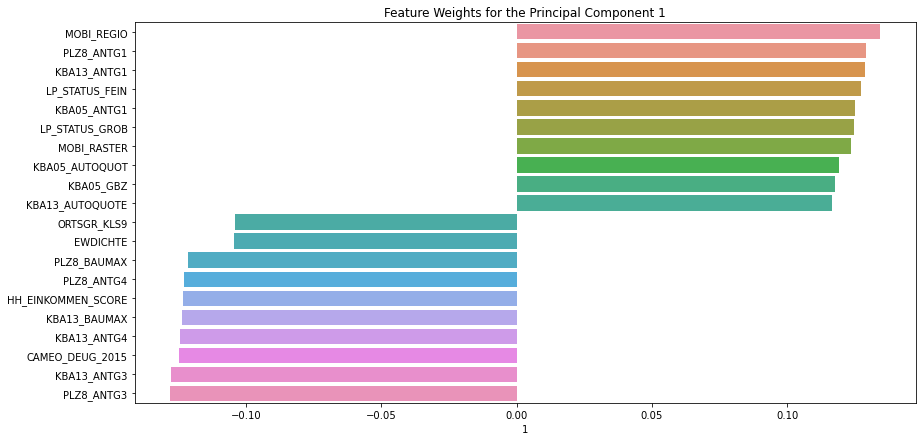

In [28]:
pca_results(1)


- The following features have the largest positive associations
    - `MOBI_REGIO` - movement patterns
    - `PLZ8_ANTG1` - number of 1-2 family houses in the PLZ8 region
    - `KBA13_ANTG1` - share of cars per 1-2 family houses
    - `LP_STATUS_FEIN` - social status (fine scale)
    - `KBA05_ANTG1` - Number of 1-2 family houses in the microcell
    - `LP_STATUS_GROB` - Social status (rough scale)
    - `MOBI_RASTER` - mobility pattern
    - `KBA05_AUTOQUOT` - share of cars per household in microcell
    
    
- The first principal component in positively associated with social status and movement patterns in small households of 1-2 family (single parents/couples without children)



- The following features have the largest negative associations
    - `PLZ8_ANTG3` - Number of 6-10 family houses in the PLZ8 region 
    - `KBA13_ANTG3` - car ownership per 6-10 family houses
    - `CAMEO_DEUG_2015` - wealth/life stage (rough scale)
    - `KBA13_ANTG4` - car ownership for 10+ family houses
    - `HH_EINKOMMEN_SCORE` - Household net income
    - `KBA13_BAUMAX` - Share of cars within most common building types within the PLZ8 


- The first principal component is most negatively associated when it comes to bigger households of at least 6 people


#####  Component 2

154 principal components explain 85.0% of the data
Features: ['ONLINE_AFFINITAET', 'D19_GESAMT_ANZ_24', 'FINANZ_SPARER', 'CJT_TYP_1', 'CJT_TYP_2', 'D19_GESAMT_ANZ_12', 'FINANZ_ANLEGER', 'D19_VERSAND_ANZ_24', 'ALTERSKATEGORIE_FEIN', 'D19_VERSAND_ANZ_12', 'CJT_TYP_3', 'VK_DHT4A', 'CJT_TYP_6', 'D19_VERSAND_DATUM', 'D19_GESAMT_DATUM', 'CJT_TYP_5', 'CJT_TYP_4', 'D19_VERSAND_ONLINE_DATUM', 'FINANZ_VORSORGER', 'D19_GESAMT_ONLINE_DATUM']


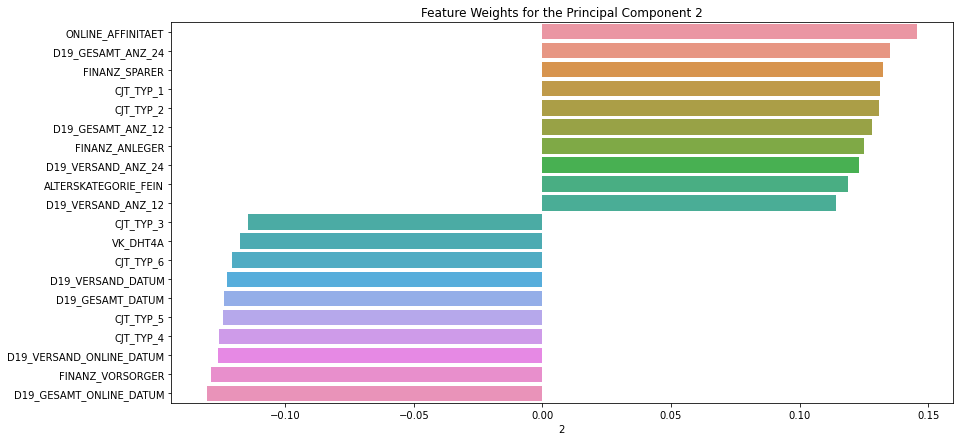

In [29]:
pca_results(2)

- The following features have the largest positve associations in the second principal component
    - `ONLINE_AFFINITAET` - online affinity
    - `D19_GESAMT_ANZ_24` - transaction activity TOTAL POOL in the last 12 to 24 months
    - `FINANZ_SPARER` - financial topology: money saver
    - `CJT_TYP_1` - Customer-Journey-Typology (Advertising- and Consumptionminimalist)?
    - `CJT_TYP_2` - Customer-Journey-Typology (Advertising- and Consumptiontraditionalist )?
    - `D19_GESAMT_ANZ_12` - transaction activity TOTAL POOL within the last 12 months 
    - `ALTERSKATEGORIE_FEIN` - Estimated age based on given name analysis (fine scale)
    - `D19_VERSAND_ANZ_12` - transaction activity MAIL-ORDER in the last 12 months
    
    
- The second principal component is positively associated with financial activities, online affinity, and estimated age


- The following features have the largest negative assocaitions in the second principal component 
    - `D19_GESAMT_ONLINE_DATUM` - actuality of the last transaction with the complete file ONLINE
    - `FINANZ_VORSORGER` - financial topology (be prepared)
    - `CJT_TYP_4` - Customer-Journey-Typology (advertisinginterested Online-shopper)?
    - `CJT_TYP_5` - Customer-Journey-Typology
    - `D19_VERSAND_ONLINE_DATUM` - actuality of the last transaction for the segment mail-order ONLINE
    - `D19_GESAMT_DATUM` - actuality of the last transaction with the complete file TOTAL
    
    
- The second principal component is most negatively associated with financial preparedness and online transaction activity date


#### Number of Components
- Since the number of principal components that explain most of the data's variability for population and the customers data are close to each other, the number to fit both datasets is 106. 


In [30]:
imp = SimpleImputer(strategy = 'mean')
azdias_imp = imp.fit_transform(azdias)
azdias_imp = pd.DataFrame(azdias_imp, columns = azdias.keys(), index = azdias.index)
azdias_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
## determine the optimal number of clusters for the data

## standardize
sc = StandardScaler()
df_sc = sc.fit_transform(azdias_imp)


## PCA Reduction
pca = PCA(n_components= 154, random_state = rs)
df_pca = pca.fit_transform(df_sc)


In [32]:
## Find optimal number of clusters via scree plot
scores = []
for i in range(1, 26):
    
    print("fitting {} clusters".format(i))
    km_i = MiniBatchKMeans(n_clusters = i, random_state = rs)
    km_i.fit(df_pca)
    
    score = km_i.inertia_
    scores.append(score)

fitting 1 clusters
fitting 2 clusters
fitting 3 clusters
fitting 4 clusters
fitting 5 clusters
fitting 6 clusters
fitting 7 clusters
fitting 8 clusters
fitting 9 clusters
fitting 10 clusters
fitting 11 clusters
fitting 12 clusters
fitting 13 clusters
fitting 14 clusters
fitting 15 clusters
fitting 16 clusters
fitting 17 clusters
fitting 18 clusters
fitting 19 clusters
fitting 20 clusters
fitting 21 clusters
fitting 22 clusters
fitting 23 clusters
fitting 24 clusters
fitting 25 clusters


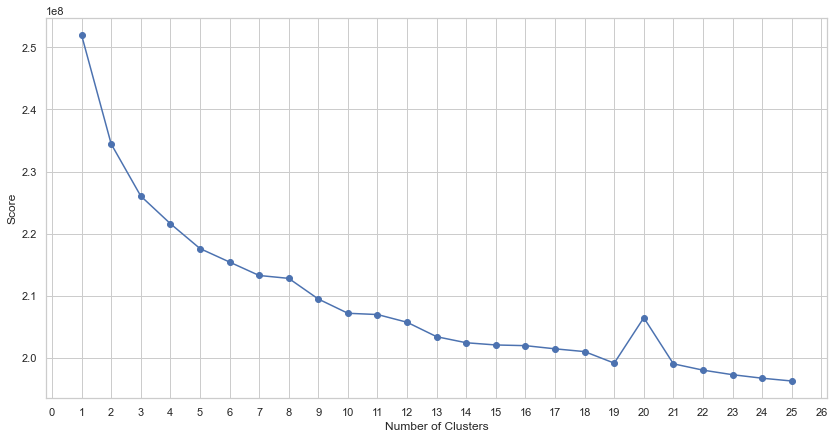

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize= (14, 7))
plt.plot(range(1, 26), scores, marker = 'o')
plt.xticks(np.arange(0, 27, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

- Using MiniBatchKmeans on the entire data gives an elbow at `k = 10`. Therefore, use 10 clusters for the analysis.

### Cluster Analysis

In [34]:
azdias_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
## standardize (start over)
sc = StandardScaler()
azdias_sc = sc.fit_transform(azdias_imp)

## PCA Reduction
pca = PCA(n_components= 154, random_state = rs)
azdias_pca = pca.fit_transform(azdias_sc)

## K-Means Clustering
km = KMeans(n_clusters = 10, random_state = rs)

azdias_labels = km.fit_predict(azdias_pca)

azdias_clust = azdias_imp.copy()
azdias_clust['CLUSTER'] = azdias_labels + 1
azdias_clust.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,CLUSTER
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8


In [37]:
azdias_clusters = pd.DataFrame({'cluster_count': azdias_clust['CLUSTER'].value_counts()})
azdias_clusters['cluster_pct'] = azdias_clusters['cluster_count']/ azdias_clust.shape[0] * 100
azdias_clusters = azdias_clusters.reset_index().rename(columns = {'index': 'cluster'})
azdias_clusters

,cluster,cluster_count,cluster_pct
0,1,110253,13.933976
1,3,106535,13.464088
2,8,103379,13.065227
3,10,100029,12.641848
4,4,83404,10.540750
5,7,72127,9.115542
6,9,62217,7.863098
7,2,52007,6.572740
8,5,51431,6.499944
9,6,49871,6.302788


#### Customer Clusters

In [38]:
## Customers - imputation

customers_imp = imp.fit_transform(customers)
df_customers_imp = pd.DataFrame(customers_imp, columns = customers.keys(), index = customers.index)

df_customers_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
143872,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
143873,1.0,8.0,8.0,0.0,0.067455,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
143874,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,7.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
143888,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [39]:
## standardize
customers_sc = sc.fit_transform(df_customers_imp)

## PCA Reduction
customers_pca = pca.fit_transform(customers_sc)

customer_labels = km.fit_predict(customers_pca)


customer_clust = df_customers_imp.copy()
customer_clust['CLUSTER'] = customer_labels + 1
customer_clust.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,CLUSTER
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8
143872,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4
143873,1.0,8.0,8.0,0.0,0.067455,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
143874,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,7.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
143888,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2


In [40]:
customer_clusters = pd.DataFrame({'cluster_count': customer_clust['CLUSTER'].value_counts()})
customer_clusters['cluster_pct'] =  customer_clusters['cluster_count']/customer_clust.shape[0] * 100
customer_clusters = customer_clusters.reset_index().rename(columns = {'index': 'cluster'})
customer_clusters


,cluster,cluster_count,cluster_pct
0,8,24460,17.363773
1,6,20441,14.510748
2,1,20097,14.266547
3,7,15066,10.695119
4,3,13285,9.430815
5,2,12836,9.112077
6,4,10959,7.779623
7,9,10669,7.573757
8,10,6760,4.798819
9,5,6295,4.468722


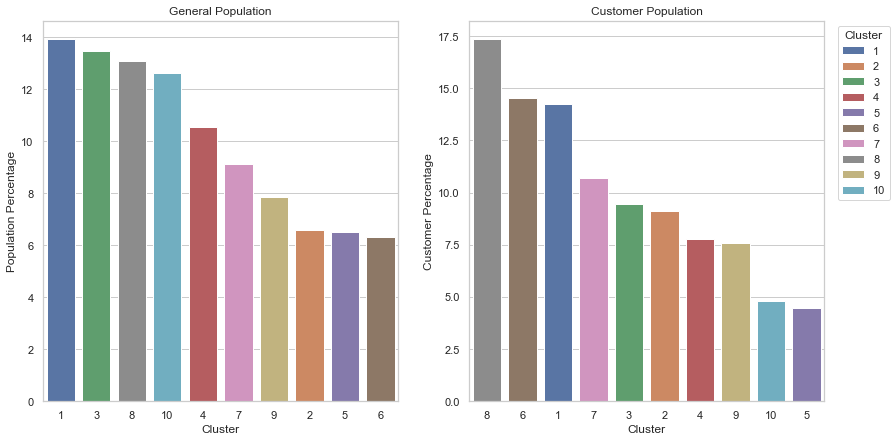

In [41]:
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
plt.title('General Population')
ax1 = sns.barplot(data = azdias_clusters, x = 'cluster', y = 'cluster_pct', hue = 'cluster', order = azdias_clusters['cluster'], dodge = False)
ax1.set_ylabel('Population Percentage')
ax1.set_xlabel('Cluster')
ax1.get_legend().remove()

plt.subplot(1, 2, 2)
plt.title('Customer Population')
ax2 = sns.barplot(data = customer_clusters, x = 'cluster', y = 'cluster_pct', hue = 'cluster', order = customer_clusters['cluster'],  dodge = False)
ax2.set_ylabel('Customer Percentage')
ax2.set_xlabel('Cluster')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.2, 1), title = 'Cluster')

plt.show()

- According to the plots above, cluster 1 is the most represented among the German population while cluster 8 is the most represented among the customer population.
- In the population group, the least represented group is cluster 6 while for the customers, the least represented is cluster 5.
    - Cluster 10 is one of the most represented groups in the population even though it is one of the least represented in the customers

- **Target audience**: customer proportion is greater than the population
- **Non-target audience**: customer proportion is less than the population

In [42]:
clust_diff = azdias_clusters.merge(customer_clusters, on = 'cluster', suffixes = ('_pop','_cust'))
## if diff > 0, then target audience
clust_diff['pct_diff'] = clust_diff['cluster_pct_cust'] - clust_diff['cluster_pct_pop']
clust_diff.sort_values(by = 'pct_diff', ascending = False, inplace = True)
clust_diff

,cluster,cluster_count_pop,cluster_pct_pop,cluster_count_cust,cluster_pct_cust,pct_diff
9,6,49871,6.302788,20441,14.510748,8.207960
2,8,103379,13.065227,24460,17.363773,4.298546
7,2,52007,6.572740,12836,9.112077,2.539337
5,7,72127,9.115542,15066,10.695119,1.579577
0,1,110253,13.933976,20097,14.266547,0.332572
6,9,62217,7.863098,10669,7.573757,-0.289341
8,5,51431,6.499944,6295,4.468722,-2.031221
4,4,83404,10.540750,10959,7.779623,-2.761126
1,3,106535,13.464088,13285,9.430815,-4.033273
3,10,100029,12.641848,6760,4.798819,-7.843029


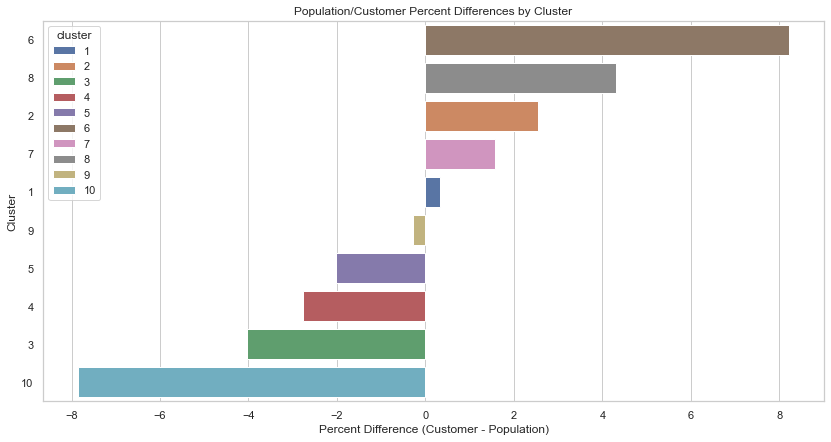

In [49]:
plt.figure(figsize = (14, 7))
sns.barplot(data = clust_diff, x = 'pct_diff', y = 'cluster', hue = 'cluster', orient = 'h', dodge = False, order = clust_diff['cluster'])
plt.xlabel('Percent Difference (Customer - Population)')
plt.ylabel('Cluster')
plt.title('Population/Customer Percent Differences by Cluster')
plt.show()


- Customer clusters 6 and 8 have a higher proportion than their population counterparts, meaning that the people in these groups are the target audiences.
    - The cluster with the largest positive margin is cluster 6


- Customer clusters 10 and 3 have a smaller proportion than their population counterparts, meaning that the people in these groups are outside the target audience
    - The cluster with the largest negative margin is cluster 10


#### Interpret Centroids

In [50]:
centroids = sc.inverse_transform(pca.inverse_transform(km.cluster_centers_))
df_centroids = pd.DataFrame(centroids, columns = df_customers_imp.keys())
df_centroids.set_index(np.arange(1,11), inplace = True)
df_centroids

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,1.434778,14.053738,10.851388,1.636965,0.032408,0.133401,3.202508,1.519015,0.029379,2.815007,...,0.050251,0.095440,0.175167,0.443913,0.208333,0.293801,0.326575,0.243691,0.037744,0.002397
2,1.614153,10.313174,9.432071,1.980452,0.091791,0.087277,2.297259,1.867242,0.055390,2.945918,...,0.024711,0.023076,0.117262,0.465533,0.353550,0.370023,0.207103,0.148007,0.050688,0.010144
3,1.358802,15.528371,11.966021,1.429248,0.007669,0.301583,3.373659,1.332423,0.009141,2.158639,...,0.017143,0.249693,0.261602,0.302514,0.113440,0.164340,0.274799,0.367771,0.139230,0.017244
4,2.121817,8.407820,8.824980,22.519954,0.448906,-0.003418,1.495411,21.656671,0.024525,3.158407,...,0.272080,0.007795,0.093479,0.276618,0.256916,0.396276,0.225116,0.109057,0.029180,-0.001853
5,2.830968,13.703598,14.220886,13.009190,0.092723,0.242649,1.806267,11.805342,0.018181,3.479606,...,0.452612,0.039606,0.083068,0.181680,0.083667,0.029848,0.076408,0.348850,0.290209,0.250304
6,1.659365,9.138929,8.783602,1.916040,0.011383,0.032931,1.747075,1.890248,0.009073,2.172482,...,0.033409,0.185834,0.234796,0.344361,0.150504,0.351646,0.299067,0.136409,0.021526,0.003534
7,1.974967,8.837083,9.010367,11.359115,0.058664,-0.004063,1.562935,10.675709,0.009251,3.573343,...,0.488007,0.032690,0.097154,0.207153,0.267107,0.394549,0.253786,0.107792,0.026127,-0.001532
8,1.585866,8.801177,8.586975,1.730673,0.021756,0.021052,1.798400,1.704588,0.020248,3.005422,...,0.054358,0.057771,0.183516,0.421331,0.259904,0.427507,0.223126,0.086687,0.016795,0.002329
9,2.270765,15.174558,15.572837,2.445004,0.018944,0.665457,2.483407,2.232499,0.008639,2.651323,...,0.041426,0.138670,0.232120,0.373009,0.131227,0.016565,0.025591,0.167056,0.474127,0.346414
10,1.362724,15.304439,11.424397,2.094466,0.032014,0.239340,3.544354,1.954378,0.021998,2.722906,...,0.050036,0.125490,0.189294,0.402698,0.193432,0.246270,0.278072,0.268467,0.107181,0.020441


In [203]:
def cluster_info(clusters, components = (1, 2), num_features = 10, top = True):
    """
    INPUT: list of clusters to show, list of principal component numbers (must be 2 in a tuple)
    """
    ## set the cluster as a variable before metling
    df_centroids_reset = df_centroids.reset_index().rename(columns = {'index': 'cluster'})
    ## set cluster as ID variable and melt 
    df_centroids_melt = df_centroids_reset.melt(id_vars = ['cluster'], var_name = 'feature')
    
    ## PCA for first values
    

    
    ## PCA for second value
    if top:
        pca1_features = pca_results(components[0], return_columns = True)[:num_features]
        pca2_features = pca_results(components[1], return_columns = True)[:num_features]
    else:
        pca1_features = pca_results(components[0], return_columns = True)[-num_features:]
        pca2_features = pca_results(components[1], return_columns = True)[-num_features:]
        
        
    pca1_centroids = df_centroids_melt[(df_centroids_melt['feature'].isin(pca1_features)) &
                                  ((df_centroids_melt['cluster'].isin(clusters)))]
    
    pca1_pivot = pca1_centroids.pivot(columns = 'cluster', index = 'feature', values = 'value')
    
    
    pca2_centroids = df_centroids_melt[(df_centroids_melt['feature'].isin(pca2_features)) &
                                  ((df_centroids_melt['cluster'].isin(clusters)))]
    
    pca2_pivot = pca2_centroids.pivot(columns = 'cluster', index = 'feature', values = 'value')

    
    plt.figure(figsize = (30, 14))
    plt.suptitle('Feature Centroids', fontsize = 22)
    plt.subplot(1, 2, 1)
    plt.title('Principal Component {}'.format(components[0]), fontsize = 20)
    ax1 = sns.heatmap(pca1_pivot, annot = True, cmap = 'mako_r', cbar = False,
                     annot_kws={'size':18})
    ax1.set_ylabel('Feature', fontsize = 19)
    ax1.set_xlabel('Cluster', fontsize = 19)
    plt.xticks(fontsize = 22)
    
    
    
    plt.subplot(1, 2, 2)
    plt.title('Principal Component {}'.format(components[1]), fontsize = 20)
    ax2 = sns.heatmap(pca2_pivot, annot = True, fmt = '.1f', cmap = 'mako_r', annot_kws={'size':16})
    ax2.set_ylabel(' ')
    ax2.set_xlabel('Cluster', fontsize = 19)
    plt.xticks(fontsize = 22)
    
    plt.show()

##### Target Customers

In [199]:
## features are ordered according to PC weight in descending order
target_clusters = [6, 8]
pc1_features = pca_results(1, return_columns = True)[:10]
df_centroids.loc[target_clusters, pc1_features]

,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,MOBI_RASTER,KBA05_AUTOQUOT,KBA05_GBZ,KBA13_AUTOQUOTE
6,4.185901,3.021131,2.881625,8.127513,2.654034,3.829487,3.644259,3.953545,4.106498,3.756679
8,4.059856,2.706282,2.548953,8.683219,2.775391,4.280424,3.114545,3.695591,3.963747,2.882741


In [182]:
pc2_features = pca_results(2, return_columns = True)[:10]
df_centroids.loc[target_clusters, pc2_features]

,ONLINE_AFFINITAET,D19_GESAMT_ANZ_24,FINANZ_SPARER,CJT_TYP_1,CJT_TYP_2,D19_GESAMT_ANZ_12,FINANZ_ANLEGER,D19_VERSAND_ANZ_24,ALTERSKATEGORIE_FEIN,D19_VERSAND_ANZ_12
6,2.203201,0.765519,1.161430,1.711750,1.413261,0.356971,1.628114,0.530464,8.783602,0.225479
8,2.322041,0.760948,1.080356,1.505663,1.437180,0.333233,1.095980,0.530227,8.586975,0.207153
2,3.117103,1.849467,1.192402,1.684749,1.682678,1.169491,1.083431,1.540593,9.432071,0.959576
7,1.978888,1.034556,1.276266,1.795548,1.771196,0.602668,1.484662,0.852841,9.010367,0.490000


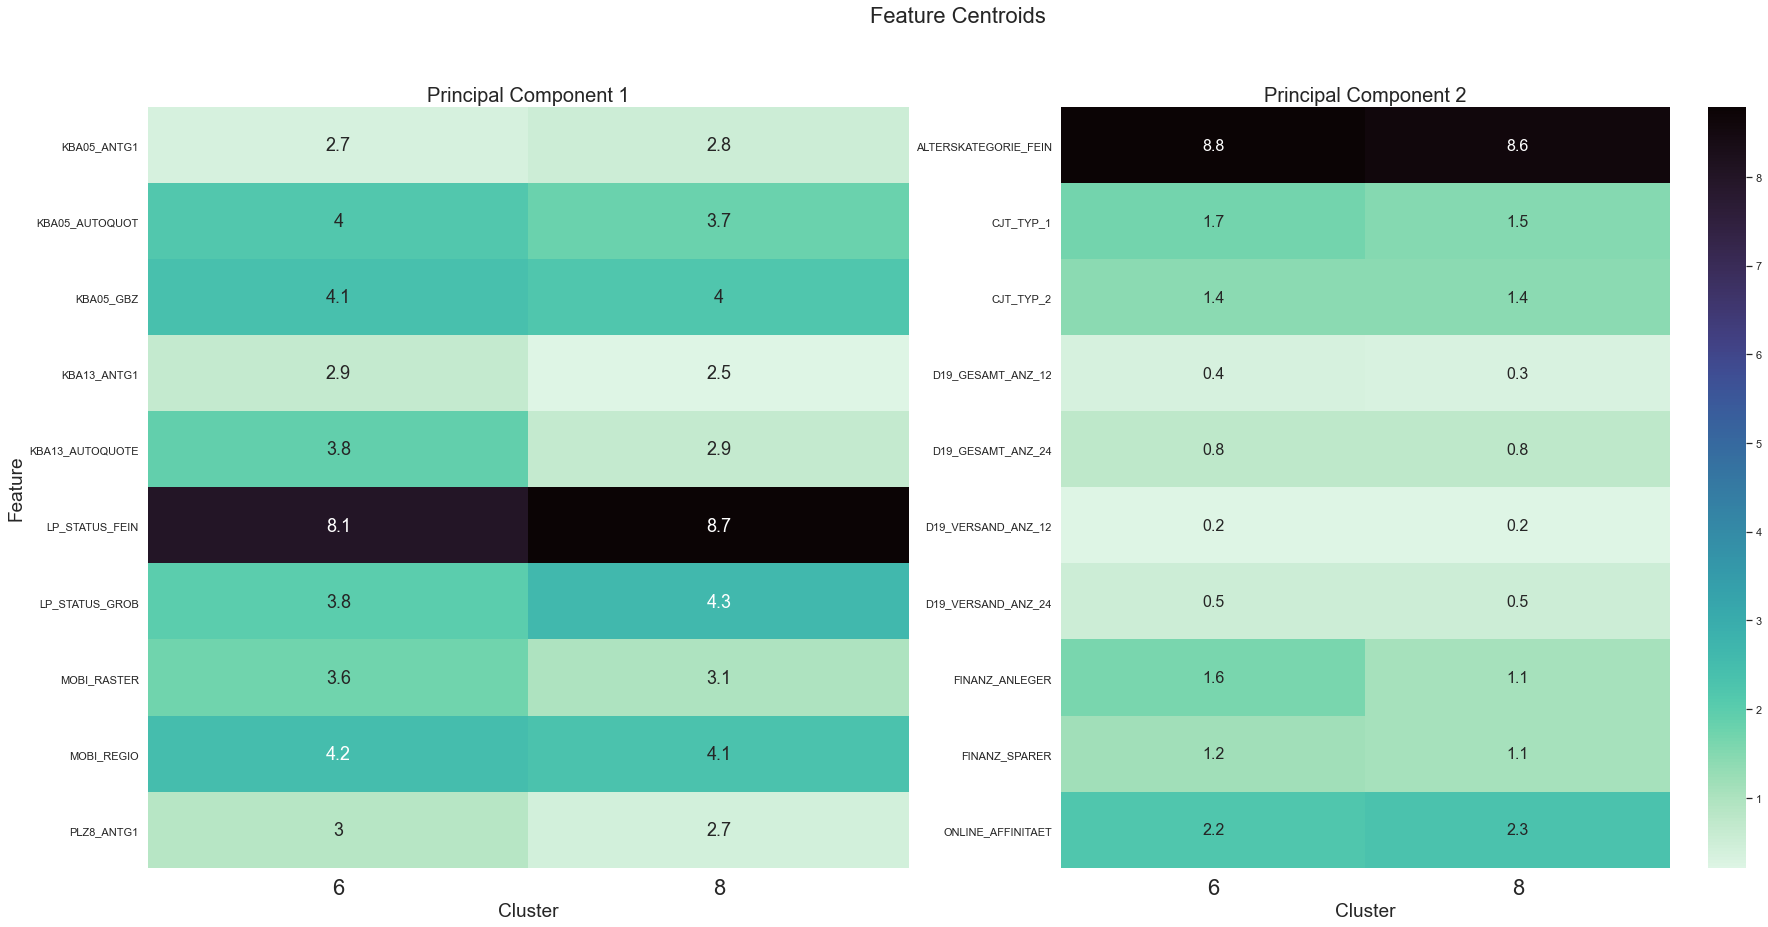

In [204]:
cluster_info(target_clusters)

In [238]:
lo = customer_clust.groupby(['CLUSTER']).mean()[['ALTERSKATEGORIE_FEIN']]
lo

,ALTERSKATEGORIE_FEIN
CLUSTER,
1,10.787484
2,9.542026
3,11.852860
4,8.812913
5,14.129059
6,8.866219
7,9.015925
8,8.602514
9,15.553202


#### Cluster 6


**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 8 -> new houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 

**Component 2**

- `ALTERSKATEGORIE_FEIN` = 9 -> age group born in late 1930s
- `D19_GESAMT_ANZ_12` = 0 -> no known financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 1 -> very low transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` =0 -> no activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 1 -> very low activity in transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 2 -> high financial investment
- `FINANZ_SPARER` = 1 -> very high money saving
- `ONLINE_AFFINITAET` = 2 -> middle-level online affinity



#### Cluster 8

**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 9 -> houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 9 -> age group born in late 1930s
- `D19_GESAMT_ANZ_12` = 0 -> no financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 1 -> very low transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 0 -> no activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 1 -> very low activity in transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 1 -> very high financial investment
- `FINANZ_SPARER` = 1 -> very high money saving
- `ONLINE_AFFINITAET` = 2 -> middle-level online affinity



#### Target Customer Description

- This target customer groups represent elderly houseowners born in the late 1930s. They live in single or double family homesn in large communities and have small mobility in society. These people tend to have very high retirement funds due to large scales in money saving and investments. Thile they have a moderate online affinity, they have little to no transaction activity in mail orders over the past 2 years.




##### Non-Target Customers

In [196]:
non_target_clusters = [3, 10]
df_centroids.loc[non_target_clusters, pc1_features]

,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,MOBI_RASTER,KBA05_AUTOQUOT,KBA05_GBZ,KBA13_AUTOQUOTE
3,4.428802,3.130235,2.997082,8.523316,2.789302,3.963760,4.084440,4.249132,4.278113,3.988149
10,4.077822,2.742546,2.596521,8.359195,2.637384,4.066384,3.366577,3.851029,3.986500,3.180645


In [191]:
df_centroids.loc[non_target_clusters, pc2_features]

,ONLINE_AFFINITAET,D19_GESAMT_ANZ_24,FINANZ_SPARER,CJT_TYP_1,CJT_TYP_2,D19_GESAMT_ANZ_12,FINANZ_ANLEGER,D19_VERSAND_ANZ_24,ALTERSKATEGORIE_FEIN,D19_VERSAND_ANZ_12
3,3.980816,3.391151,1.505979,2.169793,1.774209,2.356541,2.206228,3.010507,11.966021,2.064936
10,4.246647,4.628760,1.561691,2.048195,1.846521,3.722236,1.669504,3.330096,11.424397,2.450540


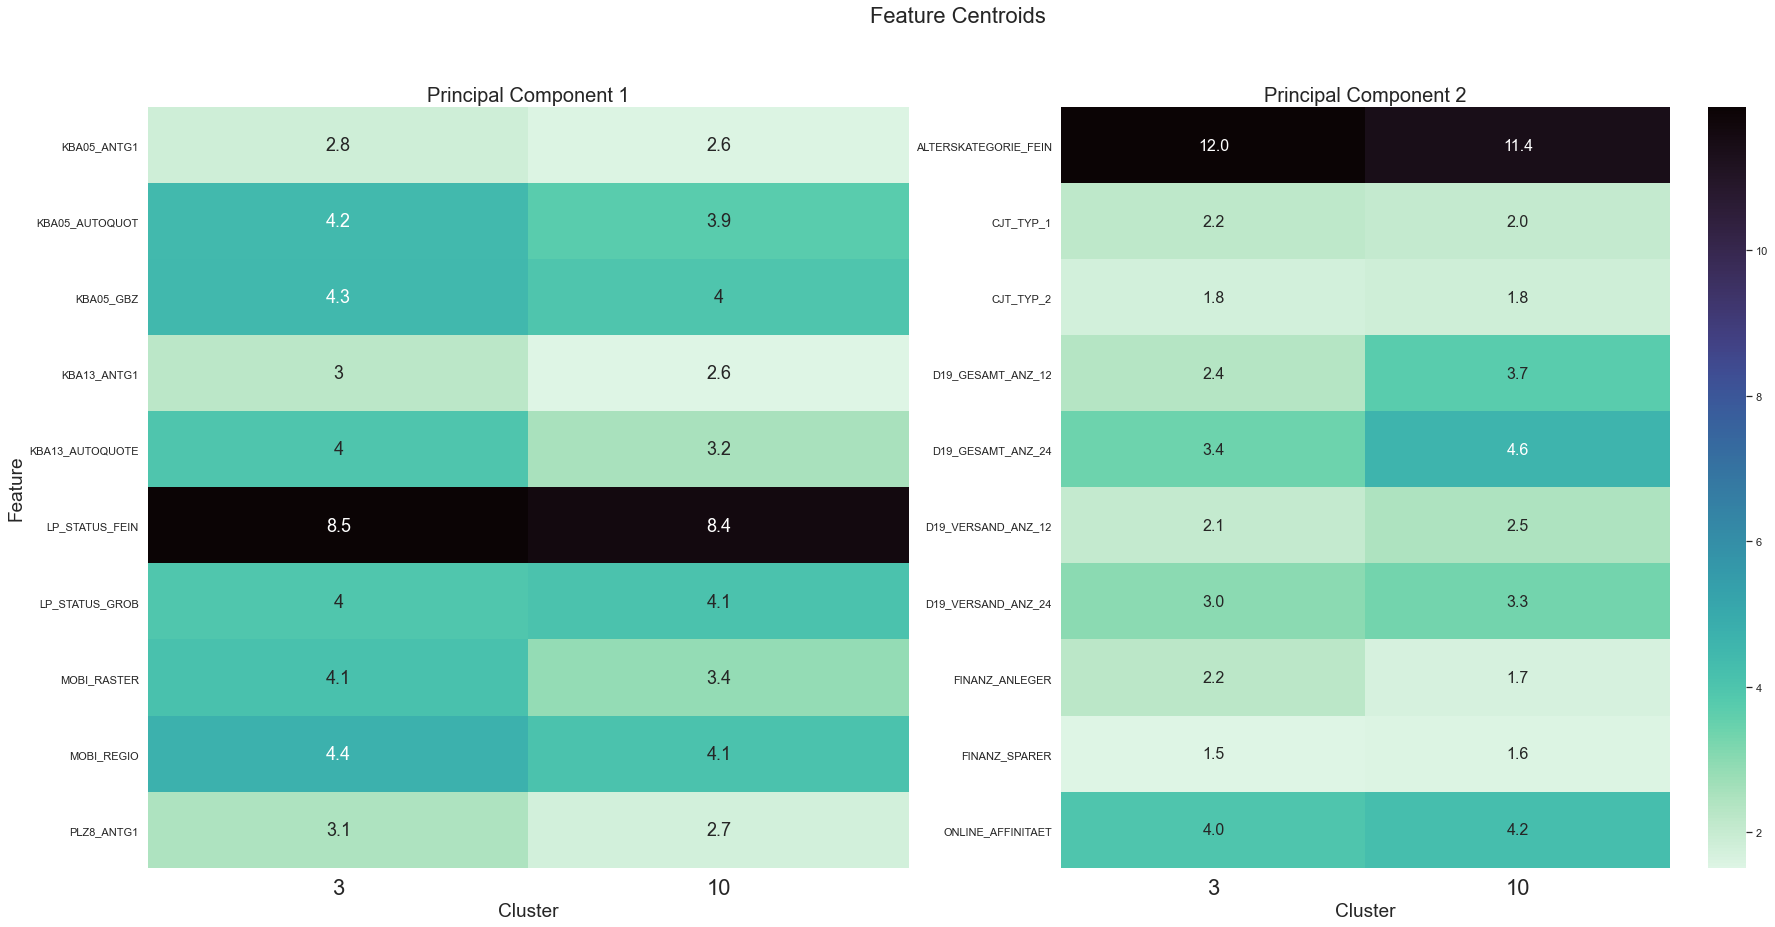

In [192]:
cluster_info(non_target_clusters)

#### Cluster 3

**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 9 -> houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 12 -> age group born in early 1950s
- `D19_GESAMT_ANZ_12` = 2 -> low financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 3 -> slightly increased transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 2 -> low activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 3 -> slightly increased transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 2 -> high financial investment
- `FINANZ_SPARER` = 2 -> high money saving
- `ONLINE_AFFINITAET` = 4 -> very high online affinity

#### Cluster 10

**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 8 -> new houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 11 -> age group born in late 1940s
- `D19_GESAMT_ANZ_12` = 4 -> increased financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 4 -> increased transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 3 -> slightly increased in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 3 -> slightly increased transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 2 -> high financial investment
- `FINANZ_SPARER` = 2 -> high money saving
- `ONLINE_AFFINITAET` = 4 -> very high online affinity

#### Non-Target Customer Description

- The non-target groups represent younger houseowners born in the late 1940s to early 1950s. Like the target groups, these people live in single or double family homes in large communities and have small mobility in society. However, they tend to have high financial scales in money saving and investments. Also, they have a very high online affinity, as well as higher transaction activities in mail orders over the past 2 years.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [256]:
from sklearn.model_selection import train_test_split

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
## clean the data according to the clean_data function
mailout_train = clean_data(mailout_train)

In [217]:

mailout_train = pd.read_csv('Udacity_MAILOUT_TRAIN_CLEANED.csv', index_col = 'LNR')
mailout_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,0
1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0,1,0,0,0,0,0,1,0,0
1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,0,0,0,1,0,0,0,0,0,0
1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,0,0,0,1,0,0,0,0,0,0
1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

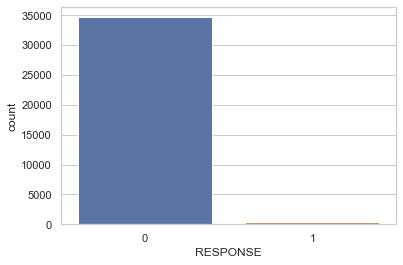

In [209]:
sns.countplot(data = mailout_train, x = 'RESPONSE')

In [223]:
len(set(mailout_train.index))

35094

In [228]:
## Customer IDs in the training data who are in the CUSTOMERS data
len(set(mailout_train.index) - set(customers.index))

9626

#### Train/Test Split

In [281]:
mailout_X = mailout_train.drop(columns = 'RESPONSE')
mailout_Y = mailout_train['RESPONSE']

In [282]:
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_Y, test_size = 0.2, random_state = rs)


# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28075 samples.
Testing set has 7019 samples.


#### Scaling Training Set

In [291]:
## Impute
Xtrain_imp = imp.fit_transform(X_train)

## standardize
Xtrain_sc = sc.fit_transform(Xtrain_imp)

## PCA Reduction
Xtrain_pca = pca.fit_transform(Xtrain_sc)
Xtrain_pca.shape

(28075, 154)

#### Scaling Test Set

In [284]:
## Impute
Xtest_imp = imp.fit_transform(X_test)

## standardize
Xtest_sc = sc.fit_transform(Xtest_imp)

## PCA Reduction
Xtest_pca = pca.fit_transform(Xtest_sc)
Xtest_pca.shape

(7019, 154)

### Prediction algorithms
- logistic regression
- random forest
- adaBoost
- gradient descent boosting
- XGBoost

- Select algorithm that fits best with training data

In [362]:
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#### Logistic Regression

In [364]:
def prediction_tests(learner, X_train = Xtrain_pca, X_test = Xtest_pca, y_train = y_train, y_test = y_test):
    
    ## fit model
    start = time()
    mod = learner
    mod.fit(X_train, y_train)
    end = time()
    
    ## predict by training
    pred_train = mod.predict(X_train)
    ## predict by testing set
    pred_test = mod.predict(X_test)
    
    ## timing
    timing = end - start
    print('Timing: {} s'.format(timing))
    
    accuracy_train = accuracy_score(y_train, pred_train)
    fb_train = f1_score(y_train, pred_train)
    print('Training Accuracy: {}, Training F-Score:{}'.format(accuracy_train,fb_train))

    accuracy_test = accuracy_score(y_test, pred_test)
    fb_test = f1_score(y_test, pred_test)
    print('Testing Accuracy: {}, Testing F-Score:{}'.format(accuracy_test, fb_test))
    
    

In [365]:
prediction_tests(GaussianNB())

Timing: 0.056906938552856445 s
Training Accuracy: 0.9872840605520926, Training F-Score:0.011080332409972301
Testing Accuracy: 0.9876050719475709, Testing F-Score:0.0


In [366]:
prediction_tests(LogisticRegression())

Timing: 0.23100590705871582 s
Training Accuracy: 0.9875690115761353, Training F-Score:0.0
Testing Accuracy: 0.9876050719475709, Testing F-Score:0.0


In [367]:
prediction_tests(RidgeClassifier())

Timing: 0.0751349925994873 s
Training Accuracy: 0.9875690115761353, Training F-Score:0.0
Testing Accuracy: 0.9876050719475709, Testing F-Score:0.0


In [368]:
prediction_tests(RandomForestClassifier(random_state = rs))

Timing: 52.00840711593628 s
Training Accuracy: 1.0, Training F-Score:1.0
Testing Accuracy: 0.9876050719475709, Testing F-Score:0.0


- Random Forest is very likely to overfit here due to a 'perfect' prediction accuracy for the training set

In [369]:
prediction_tests(AdaBoostClassifier(random_state = rs))

Timing: 23.655713081359863 s
Training Accuracy: 0.9876046304541407, Training F-Score:0.005714285714285714
Testing Accuracy: 0.9873201310728024, Testing F-Score:0.0


- Although not as long as a random forest, the training accuracy is similar to that of the random forest

In [370]:
prediction_tests(GradientBoostingClassifier(random_state = rs))

Timing: 122.01225805282593 s
Training Accuracy: 0.9931611754229742, Training F-Score:0.6205533596837944
Testing Accuracy: 0.9804815500783587, Testing F-Score:0.028368794326241134


- Takes too long to fit, but gives quite reasonable F-beta scores.

In [371]:
prediction_tests(SVC(random_state = rs))

Timing: 90.41978216171265 s
Training Accuracy: 0.9875690115761353, Training F-Score:0.0
Testing Accuracy: 0.9876050719475709, Testing F-Score:0.0


- Due to the F-scores above, Gradient boosting classifier will be used for this prediction

In [372]:
prediction_tests(BaggingClassifier())

Timing: 115.18446493148804 s
Training Accuracy: 0.996580587711487, Training F-Score:0.840531561461794
Testing Accuracy: 0.9873201310728024, Testing F-Score:0.02197802197802198


- The timing is lower than the Gradient Boosting, therefore use this classifier

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [230]:
len(customers)

140868

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')